# Project Overview 
By leveraging the National Poll on Healthy Aging dataset, We can conduct data-driven analysis on various topics (e.g. health insurance coverage, dental care, caregiving) to gain valuable insights into the health-related needs and concerns of the older population.

**Goal**
- The goal of this project is to develop a model using a machine learning algorithm to predict the number of doctor visits for patients aged 50 and older, categorizing these visits into predefined groups {1: 0-1 doctors, 2: 2-3 doctors, 3: 4 or more doctors } based on their physical, mental, and dental health status along with other lifestyle factors. 

**Impact**
- It may help identify patients who are more likely to be high utilizers of healthcare resources. This could enable more proactive outreach and care management to address underlying needs.
- Insurers or health systems may utilize predictions to better allocate resources and plan staffing needs.
- Clinically, insights gained might assist providers in assessing patients’ future care needs in a more data-driven manner.


**Expected Outcome**
- The expected outcome is an effective model that classifies patients into categories reflecting their healthcare needs (e.g., 0-1 doctors, 2-3 doctors, 4 or more doctors).
  

**Data**
- Origin: A subset of the National Poll on Healthy Aging (NPHA) dataset from UCI
- Link: https://archive.ics.uci.edu/dataset/936/national+poll+on+healthy+aging+(npha)
- Dataset Characteristics: Tabular
- Subject Area: Health and Medicine
- Associated Tasks: Classification
- Feature Type: Categorical
- Instances: 714
- Features: 14
- Additional Variable Information:
  Class Label for Number of Doctors Visited: The total count of different doctors the patient has seen = {
     1: 0-1 doctors, 2: 2-3 doctors, 3: 4 or more doctors }
  

**Data Problem**
- A lack of diversity in the age group: All the entries fall into the "65-80" age category.
- Imbalanced dataset in the racial or ethnic background: A significant overrepresentation of the "White, Non-Hispanic" category compared to other categories.

# Import Libraries

In [143]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from collections import Counter
import time
import warnings
warnings.filterwarnings("ignore")

# Fetch dataset 

In [144]:
national_poll_on_healthy_aging_npha = fetch_ucirepo(id=936) 
  
# data (as pandas dataframes) 
X = national_poll_on_healthy_aging_npha.data.features 
y = national_poll_on_healthy_aging_npha.data.targets

In [145]:
# Gather X and Y for visualizations
df = pd.concat([X,y], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Age                                         714 non-null    int64
 1   Physical_Health                             714 non-null    int64
 2   Mental_Health                               714 non-null    int64
 3   Dental_Health                               714 non-null    int64
 4   Employment                                  714 non-null    int64
 5   Stress_Keeps_Patient_from_Sleeping          714 non-null    int64
 6   Medication_Keeps_Patient_from_Sleeping      714 non-null    int64
 7   Pain_Keeps_Patient_from_Sleeping            714 non-null    int64
 8   Bathroom_Needs_Keeps_Patient_from_Sleeping  714 non-null    int64
 9   Uknown_Keeps_Patient_from_Sleeping          714 non-null    int64
 10  Trouble_Sleeping                      

In [146]:
df.describe()

,Age,Physical_Health,Mental_Health,Dental_Health,Employment,Stress_Keeps_Patient_from_Sleeping,Medication_Keeps_Patient_from_Sleeping,Pain_Keeps_Patient_from_Sleeping,Bathroom_Needs_Keeps_Patient_from_Sleeping,Uknown_Keeps_Patient_from_Sleeping,Trouble_Sleeping,Prescription_Sleep_Medication,Race,Gender,Number_of_Doctors_Visited
count,714.0,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.00000,714.000000
mean,2.0,2.794118,1.988796,3.009804,2.806723,0.247899,0.056022,0.218487,0.504202,0.417367,2.407563,2.829132,1.425770,1.55042,2.112045
std,0.0,0.900939,0.939928,1.361117,0.586582,0.432096,0.230126,0.413510,0.500333,0.493470,0.670349,0.546767,1.003896,0.49780,0.683441
min,2.0,-1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,1.00000,1.000000
25%,2.0,2.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1.00000,2.000000
50%,2.0,3.000000,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,1.000000,2.00000,2.000000
75%,2.0,3.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.00000,3.000000
max,2.0,5.000000,5.000000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,5.000000,2.00000,3.000000


In [147]:
print(df.head(3))

   Age  Physical_Health  Mental_Health  Dental_Health  Employment  \
0    2                4              3              3           3   
1    2                4              2              3           3   
2    2                3              2              3           3   

   Stress_Keeps_Patient_from_Sleeping  Medication_Keeps_Patient_from_Sleeping  \
0                                   0                                       0   
1                                   1                                       0   
2                                   0                                       0   

   Pain_Keeps_Patient_from_Sleeping  \
0                                 0   
1                                 0   
2                                 0   

   Bathroom_Needs_Keeps_Patient_from_Sleeping  \
0                                           0   
1                                           1   
2                                           0   

   Uknown_Keeps_Patient_from_Sleeping  Troub

# Data Cleaning
Handling -1(Refused), -2(Not asked) values in the features.

In [148]:
# Check missing values.
df.isnull().sum()

# Filter out the rows with values -1 or -2 in the features.
for _, col in enumerate(X.columns):
    count = df[col].isin([-1, -2]).sum()
    print(col, count)
    df = df[~df[col].isin([-1, -2])]

Age 0
Physical_Health 1
Mental_Health 10
Dental_Health 3
Employment 0
Stress_Keeps_Patient_from_Sleeping 0
Medication_Keeps_Patient_from_Sleeping 0
Pain_Keeps_Patient_from_Sleeping 0
Bathroom_Needs_Keeps_Patient_from_Sleeping 0
Uknown_Keeps_Patient_from_Sleeping 0
Trouble_Sleeping 2
Prescription_Sleep_Medication 2
Race 0
Gender 0


# Analyze Class Distribution
We found bias towards Class 2. It will need to rebalance the data using techniques like SMOTE, random oversampling for underrepresented classes, or undersampling for the overrepresented class.

In [149]:
# Calculate the class distribution
class_distribution = df['Number_of_Doctors_Visited'].value_counts()
print(class_distribution)

Number_of_Doctors_Visited
2    363
3    207
1    126
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

**1. The distribution of age, race, gender**

- It shows that 100% of the entries fall into the "65-80" age category as per the patient's age group, this indicates a strong bias or imbalance in the dataset regarding age distribution.

- Based on the distribution percentages for the patient's racial or ethnic background, it appears that the dataset is imbalanced with a significant overrepresentation of the "White, Non-Hispanic" category compared to other categories. 

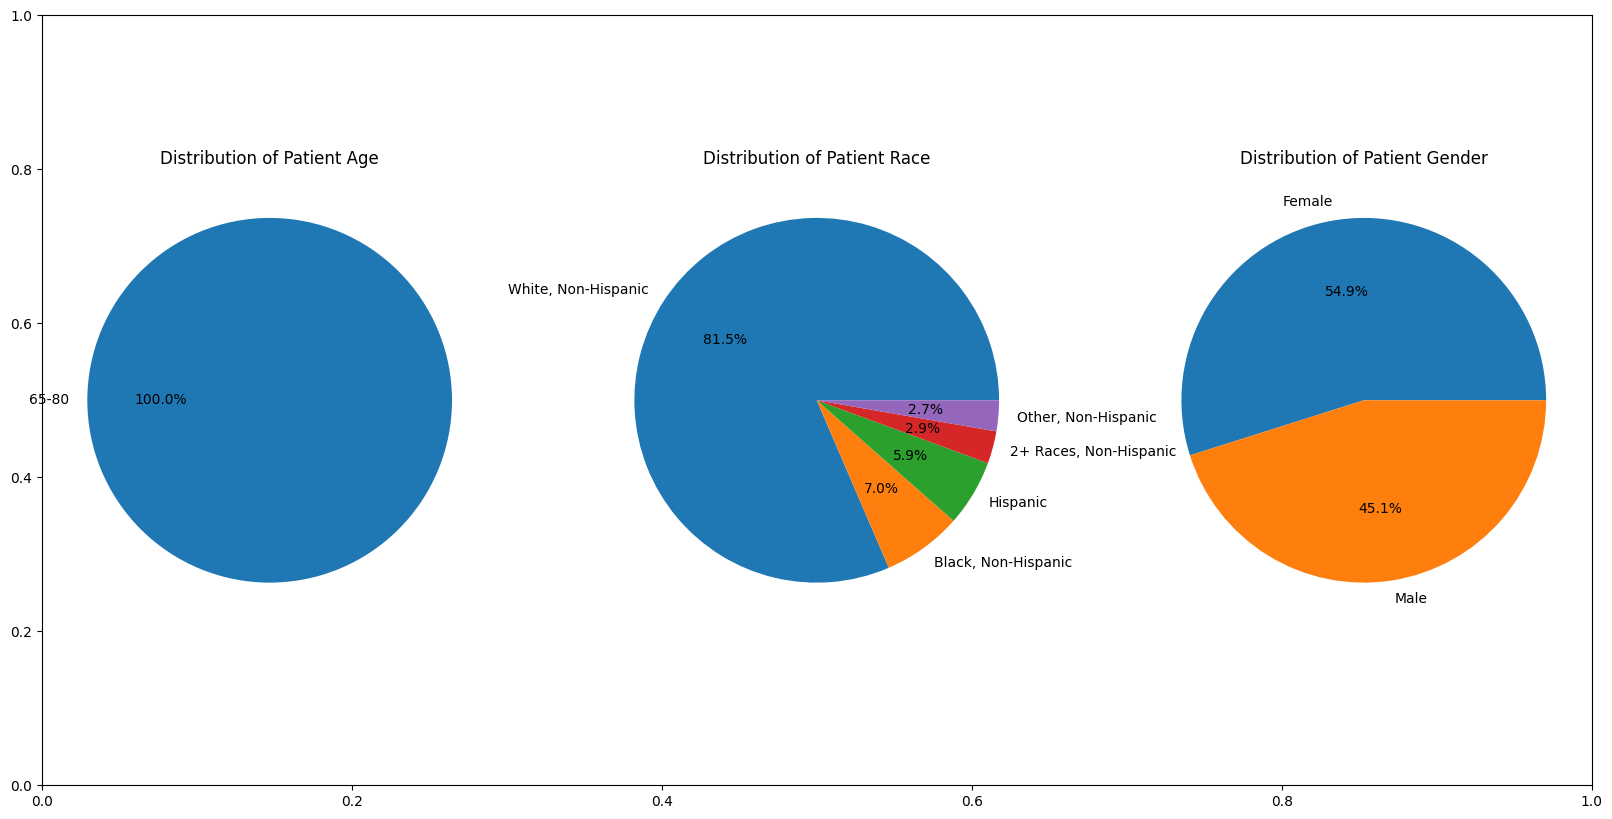

In [150]:
df_ = df.copy()

age_dict = { 1: "50-64", 2: "65-80" }
df_['Age'] = df_['Age'].map(age_dict)

race_dict = { 1: "White, Non-Hispanic", 2: "Black, Non-Hispanic", 3: "Other, Non-Hispanic", 4: "Hispanic", 5: "2+ Races, Non-Hispanic" }
df_['Race'] = df_['Race'].map(race_dict)

gender_dict = { 1: "Male", 2: "Female" }
df_['Gender'] = df_['Gender'].map(gender_dict)

plt.subplots(figsize=(20, 10))
for i, col in enumerate(['Age', 'Race' , 'Gender']):
    plt.subplot(1, 3, i + 1)
 
    x = df_[col].value_counts()
    plt.title('Distribution of Patient ' + col)
    plt.pie(x.values,
            labels=x.index,
            autopct='%1.1f%%')
 
plt.show()

**2. The distribution of physical, mental, dental health and other lifestyle factors**

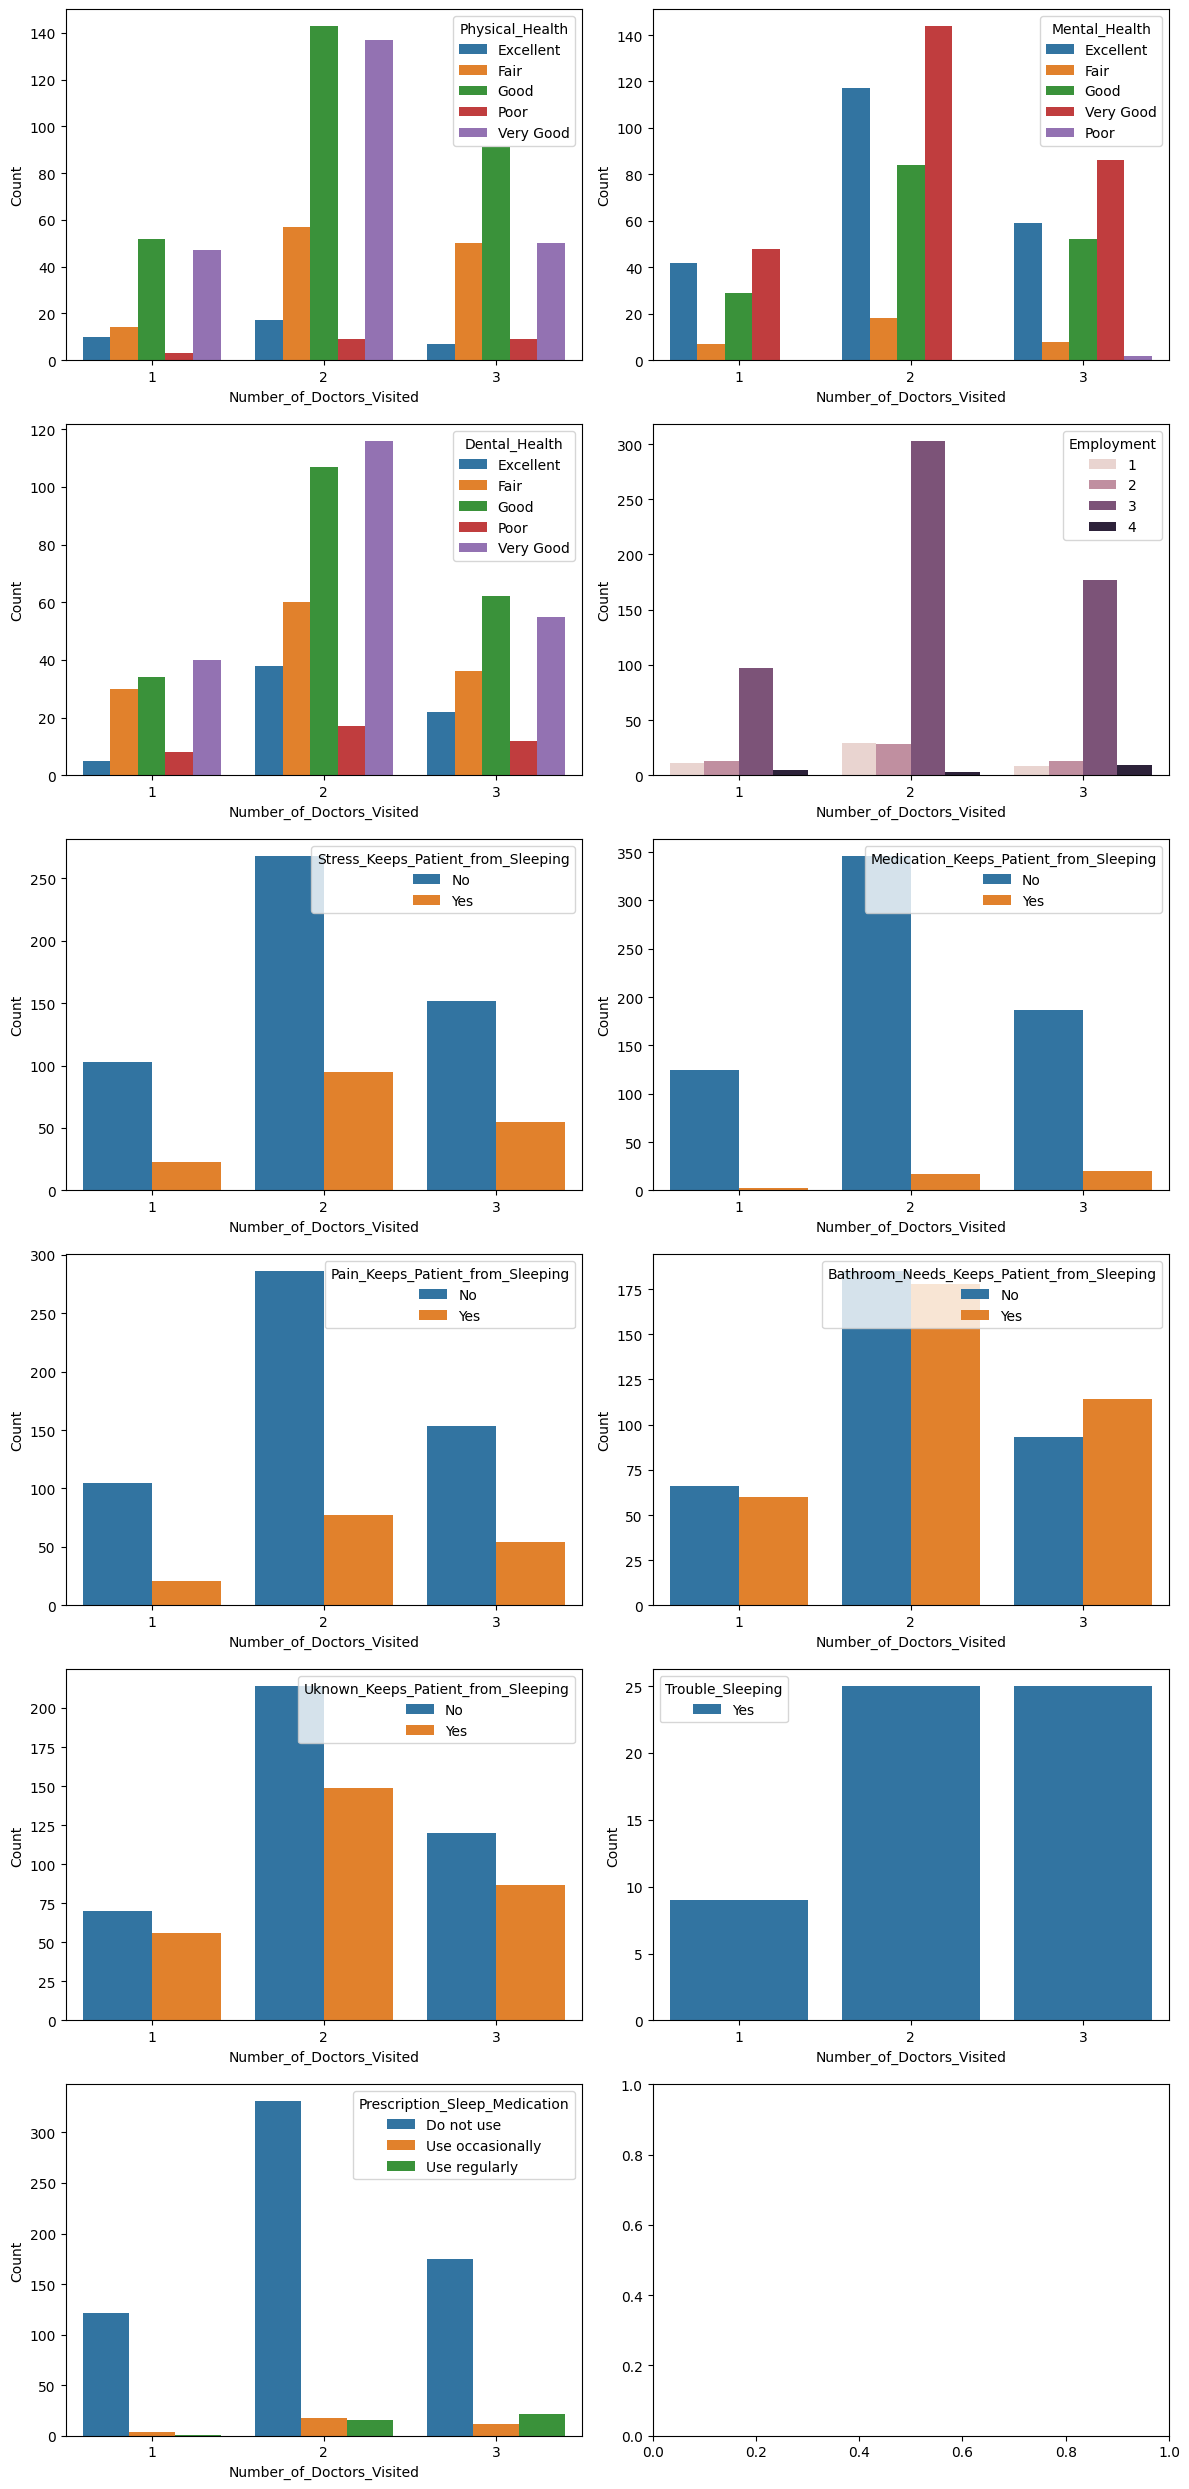

In [151]:
health_dict = { 1: "Excellent", 2: "Very Good", 3: "Good",4: "Fair", 5: "Poor" }
sleep_dict= { 0: "No", 1: "Yes" }
prescription_dict = { 1: "Use regularly", 2: "Use occasionally", 3: "Do not use" }

df_['Physical_Health'] = df_['Physical_Health'].map(health_dict)
df_['Mental_Health'] = df_['Mental_Health'].map(health_dict)
df_['Dental_Health'] = df_['Dental_Health'].map(health_dict)
df_['Stress_Keeps_Patient_from_Sleeping'] = df_['Stress_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Medication_Keeps_Patient_from_Sleeping'] = df_['Medication_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Pain_Keeps_Patient_from_Sleeping'] = df_['Pain_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Bathroom_Needs_Keeps_Patient_from_Sleeping'] = df_['Bathroom_Needs_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Uknown_Keeps_Patient_from_Sleeping'] = df_['Uknown_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Trouble_Sleeping'] = df_['Trouble_Sleeping'].map(sleep_dict)
df_['Prescription_Sleep_Medication'] = df_['Prescription_Sleep_Medication'].map(prescription_dict)


cols = X.drop(columns=['Race', 'Age', 'Gender'])
fig, axes = plt.subplots(6, 2, figsize=(12, 25))

for i, col in enumerate(cols):
    row = i // 2
    column = i % 2
    count_data = df_.groupby([col, 'Number_of_Doctors_Visited']).size().reset_index(name='Count')
    
    # Plot the barplot for each state
    sns.barplot(x='Number_of_Doctors_Visited', y='Count', hue=col, data=count_data, ax=axes[row, column])
    # axes[row, column].set_title(col)

plt.tight_layout()
plt.show()

# Correlation Analysis
`Physical_Health` have strong correlation with `Number_of_Doctors_Visited` and strong interrelation with `Mental_Health`, indicating it is a significant predictor of healthcare utilization and overall health status.

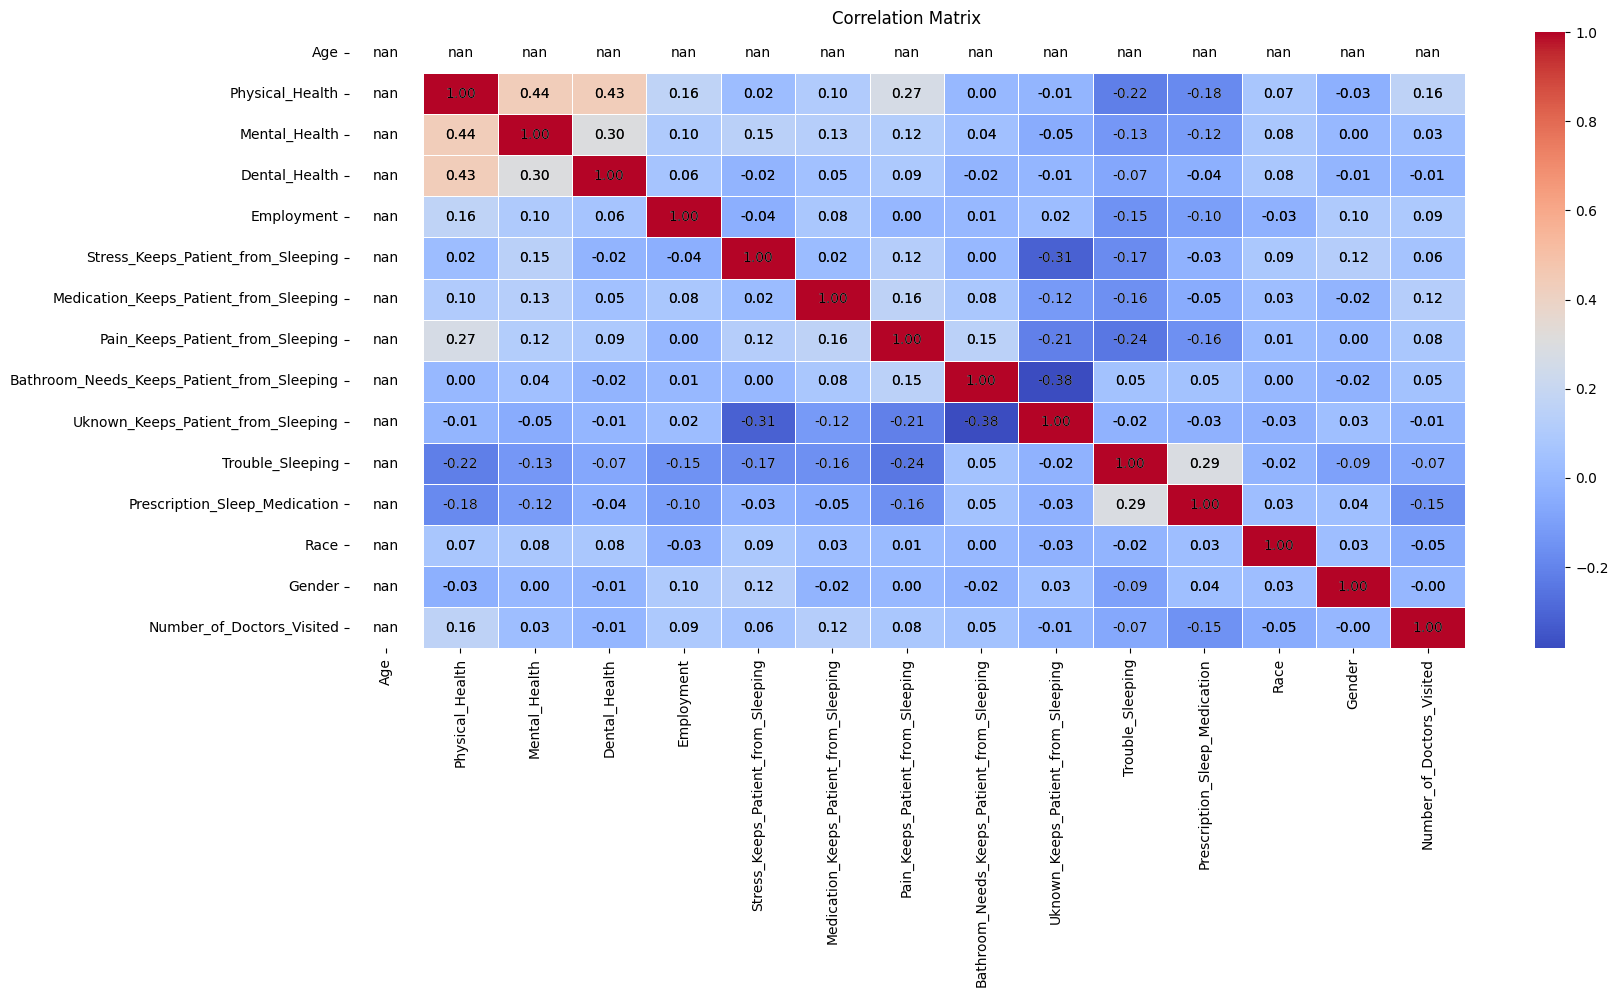

In [152]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# Add annotations to the heatmap
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = f"{corr_matrix.iloc[i, j]:.2f}"
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

plt.title("Correlation Matrix")
plt.show()

# Analysing Feature Importances

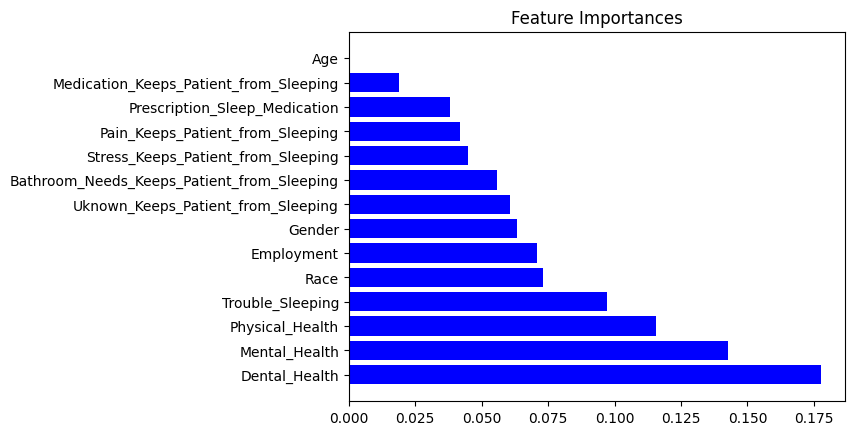

In [153]:
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X, y)

# Extract Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.show()

# Feature Selection
In an effort to reduce dimensionality, one of approches We tried to combine various sleep-related disturbances into a single metric based on the Feature Importances and the Correlation Matrix but We didn't see a significant impact on model performance.
Domain experts could potentially provide insights into known clinical/causal links between certain variables.  

In [154]:
columns_to_drop = ['Age']
X = X.drop(columns=columns_to_drop)

# Model Development
**1. Spliting into Train and Test**

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**2. SMOTE for Balancing Data**

The Synthetic Minority Oversampling Technique to generate synthetic samples for the minority class based on nearest neighbors.

We tested Random Forest, SVC models without resampling, the models were performing well on the majority class which is Class 2 but poorly on the minority class - Precision, recall, and F1-score were all 0 on Class 1. 
```
🚀 Random Forest
Average accuracy: 0.45385367762128326
Confusion Matrix:
 [[ 3 19  6]
 [ 1 53 20]
 [ 2 28 11]]
Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.11      0.18        28
           2       0.53      0.72      0.61        74
           3       0.30      0.27      0.28        41

    accuracy                           0.47       143
   macro avg       0.44      0.36      0.36       143
weighted avg       0.46      0.47      0.43       143

🚀 SVC
Average accuracy: 0.5126564945226917
Confusion Matrix:
 [[ 0 27  1]
 [ 0 68  6]
 [ 0 34  7]]
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        28
           2       0.53      0.92      0.67        74
           3       0.50      0.17      0.25        41

    accuracy                           0.52       143
   macro avg       0.34      0.36      0.31       143
weighted avg       0.42      0.52      0.42       143
```
After oversampling using SMOTE, it shows improved Average Accuracy 0.58% on Random Forest and marginally improved the recall for Class 1 and Class 3.

In [156]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_resampled['Number_of_Doctors_Visited']))

Class distribution after SMOTE: Counter({3: 298, 2: 298, 1: 298})


**3. Feature Scaling**

In [157]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

**4. Machine Learning Modeling**

Prediction and Evaluation: The model’s performance is evaluated using accuracy and a detailed classification report, which includes precision, recall, and F1-score for each class.
- Precision: Indicates the accuracy of positive predictions.
- Recall: Indicates the ability to find all positive instances.
- F1-Score: Harmonic mean of precision and recall.

In [158]:
# Evaluate the performance of the model

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print evaluation results
    print("Confusion Matrix:\n", matrix)
    print("Classification Report:\n", class_report)

In [169]:
X_scaled = np.vstack((X_train_scaled, X_test_scaled))
y = np.concatenate((y_train_resampled, y_test))

# Initializing Models
models = {
    "LogisticRegression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(kernel ='linear'),
    "DecisionTree": DecisionTreeClassifier()
}

cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# Producing cross validation score for the models
for model_name in models:
    model = models[model_name]
    
    # Evaluate the model's accuracy using cross-validation
    accuracies = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    
    print("🚀", model_name)
    print("Average accuracy:", np.mean(accuracies))

    model.fit(X_train_scaled, y_train_resampled)
    evaluate(model, X_test_scaled, y_test)
   

🚀 LogisticRegression
Average accuracy: 0.4271377893950709
Confusion Matrix:
 [[ 4 14 10]
 [17 26 31]
 [ 7 15 19]]
Classification Report:
               precision    recall  f1-score   support

           1       0.14      0.14      0.14        28
           2       0.47      0.35      0.40        74
           3       0.32      0.46      0.38        41

    accuracy                           0.34       143
   macro avg       0.31      0.32      0.31       143
weighted avg       0.36      0.34      0.34       143

🚀 Random Forest
Average accuracy: 0.6055358476474982
Confusion Matrix:
 [[ 5 14  9]
 [14 38 22]
 [ 3 22 16]]
Classification Report:
               precision    recall  f1-score   support

           1       0.23      0.18      0.20        28
           2       0.51      0.51      0.51        74
           3       0.34      0.39      0.36        41

    accuracy                           0.41       143
   macro avg       0.36      0.36      0.36       143
weighted avg       0.4

##### **5. Cross-validation Results** 

Based on the results above, the Random Forest model performs better compared to the other models.
- Average Accuracy: 60.55% (reported as higher, but confusion matrix suggests lower effective accuracy)
- Reported Accuracy: 41% as the effective accuracy, which reflects the proportion of total correct predictions across all classes.

# Bayesian Hyperparameter Optimization

**1. BayesSearchCV with RandomForestClassifier** 

In the first approach, we will use BayesSearchCV to perform hyperparameter optimization for the Random Forest algorithm. BayesSearchCV from the scikit-optimize library is a powerful tool for hyperparameter tuning that uses Bayesian optimization techniques. 

In [207]:
np.int = np.int_
y_train = y_train_resampled['Number_of_Doctors_Visited'].values.ravel()

# Define the parameter search space
search_spaces = {
    'n_estimators': (10, 200),
    'max_depth': (1, 15),
    'min_samples_split': (3, 20),
    'min_samples_leaf': (2, 10)
}

# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=search_spaces,
    n_iter=50,  
    cv=5,  
    n_jobs=-1,  
    scoring='accuracy'  
)

start_time = time.time()
# Fit the optimizer to data
bayes_cv.fit(X_train_scaled, y_train)
elapsed_time  = time.time() - start_time
print("Elapsed time: %s" % format(elapsed_time, ".2f"))

# Evaluate the performance of the best estimator
print("Train score: %s" % bayes_cv.best_score_)
print("Best params: %s" % str(bayes_cv.best_params_))

evaluate(bayes_cv.best_estimator_, X_test_scaled, y_test)

Elapsed time: 61.67
Train score: 0.6197790471407947
Best params: OrderedDict([('max_depth', 15), ('min_samples_leaf', 2), ('min_samples_split', 3), ('n_estimators', 200)])
Confusion Matrix:
 [[ 4 13 11]
 [14 37 23]
 [ 5 18 18]]
Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.14      0.16        28
           2       0.54      0.50      0.52        74
           3       0.35      0.44      0.39        41

    accuracy                           0.41       143
   macro avg       0.35      0.36      0.36       143
weighted avg       0.41      0.41      0.41       143



**2. BayesSearchCV with SVC**

In [208]:
# Define the parameter search space
search_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'poly']),
    'degree': Integer(1, 8)
}

# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=SVC(),
    search_spaces=search_space,
    scoring = 'accuracy',
    cv = 5,
    n_iter = 50,
    n_jobs = -1,
    random_state = 42 
)

start_time = time.time()
# Fit the optimizer to data
bayes_cv.fit(X_train_scaled, y_train)
elapsed_time  = time.time() - start_time
print("Elapsed time: %s" % format(elapsed_time, ".2f"))

# Evaluate the performance of the best estimator
print("Train score: %s" % bayes_cv.best_score_)
print("Best params: %s" % str(bayes_cv.best_params_))

evaluate(bayes_cv.best_estimator_, X_test_scaled, y_test)

Elapsed time: 360.75
Train score: 0.6130374741070869
Best params: OrderedDict([('C', 1000000.0), ('degree', 1), ('gamma', 10.0), ('kernel', 'rbf')])
Confusion Matrix:
 [[ 3 14 11]
 [12 42 20]
 [ 3 27 11]]
Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.11      0.13        28
           2       0.51      0.57      0.54        74
           3       0.26      0.27      0.27        41

    accuracy                           0.39       143
   macro avg       0.31      0.31      0.31       143
weighted avg       0.37      0.39      0.38       143



**3. BayesSearchCV with DecisionTreeClassifier**

In [209]:
# Define the parameter search space
search_spaces = {
    'criterion': ['gini', 'entropy'],
    'max_depth': (1, 15),
    'min_samples_split': (3, 4),
    'min_samples_leaf': (2, 3),
}

# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=DecisionTreeClassifier(),
    search_spaces=search_spaces,
    n_iter=50,  
    cv=5, 
    n_jobs=-1,  
    scoring='accuracy'  
)

start_time = time.time()
# Fit the optimizer to data
bayes_cv.fit(X_train_scaled, y_train)
elapsed_time  = time.time() - start_time
print("Elapsed time: %s" % format(elapsed_time, ".2f"))

# Evaluate the performance of the best estimator
print("Train score: %s" % bayes_cv.best_score_)
print("Best params: %s" % str(bayes_cv.best_params_))

evaluate(bayes_cv.best_estimator_, X_test_scaled, y_test)

Elapsed time: 56.26
Train score: 0.5626702655200553
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 15), ('min_samples_leaf', 2), ('min_samples_split', 4)])
Confusion Matrix:
 [[ 8 13  7]
 [17 39 18]
 [10 21 10]]
Classification Report:
               precision    recall  f1-score   support

           1       0.23      0.29      0.25        28
           2       0.53      0.53      0.53        74
           3       0.29      0.24      0.26        41

    accuracy                           0.40       143
   macro avg       0.35      0.35      0.35       143
weighted avg       0.40      0.40      0.40       143



## Model Selection

Based on the results for RandomForest, SVC (Support Vector Classifier), and Decision Tree models, RandomForest has the highest training score. In terms of test accuracy, RandomForest again slightly outperforms the other models but all are fairly close. 

In the precision, recall, and f1 scores, RandomForest generally shows balanced performance across classes but struggles with Class 1. SVC shows slightly better performance for Class 2, which is the majority class, it might be better at identifying more common scenarios. Decision Tree shows a diverse but not significantly better performance pattern.

SVC might offer better performance for the specific task but **RandomForest** would be a strong choice on the grounds of interpretability, computational efficiency, and **more balanced class performance**. These factors are crucial in healthcare applications. 

# References
1. How to Use SMOTE for an Imbalanced Dataset, <https://www.turing.com/kb/smote-for-an-imbalanced-dataset>